In [3]:
#conda install -c conda-forge geopandas

In [1]:
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [2]:
from input_enem import categorical_labels

In [3]:
sh_uf = gpd.read_file("../Utils/GEO/shp/BR_UF_2021/BR_UF_2021.shp")
sh_mun = gpd.read_file("../Utils/GEO/shp/BR_Municipios_2021/BR_Municipios_2021.shp")
sh_br = gpd.read_file("../Utils/GEO/shp/BR_Pais_2021/BR_Pais_2021.shp")

## Funções

In [75]:
def get_trienio(df, col_name='NU_ANO'):
    df_19 = df[df[col_name] == 2019]
    df_20 = df[df[col_name] == 2020]
    df_21 = df[df[col_name] == 2021]
    return [df_19, df_20, df_21]

In [76]:
def get_trienio_pble(df):
    df_19 = df[df['ATIVADO_2019']=='Sim']
    df_20 = df[df['ATIVADO_2020']=='Sim']
    df_21 = df[df['ATIVADO_2021']=='Sim']
    return [df_19, df_20, df_21]

## Views

### Visualizando Score Médio dos estudantes de escola pública por município

In [8]:
med_enem = pd.read_parquet('../../Resultados/Agg/ENEM/anual/notas/medio_nota_pub_pvd.parquet').reset_index().drop(columns=['TP_DEPENDENCIA_ADM_ESC','index','NO_MUNICIPIO_ESC','SG_UF_ESC'])
median_enem = pd.read_parquet('../../Resultados/Agg/ENEM/2019/pub_pvd_mediana.parquet').reset_index()
med_enem.TP_ESCOLA = med_enem.TP_ESCOLA.replace(categorical_labels['TP_ESCOLA'])
med_enem.NU_ANO = med_enem.NU_ANO.astype(int)

In [11]:
# Selecionando apenas escolas públicas
med_enem_pub = med_enem[med_enem.TP_ESCOLA == 'Pública']

In [12]:
# Atribuíndo dados ao georreferenciamento
geo_med_enem_pub = sh_mun.merge(med_enem_pub, left_on='CD_MUN', right_on='CO_MUNICIPIO_ESC', how='left')

In [28]:
# Agrupando notas em quartis
geo_med_enem_pub['NT_MEDIA_QUARTIL'] = pd.qcut(geo_med_enem_pub['NT_MEDIA'], q=4, labels=['Primeiro Quartil', 'Segundo Quartil', 'Terceiro Quartil', 'Quarto Quartil'])

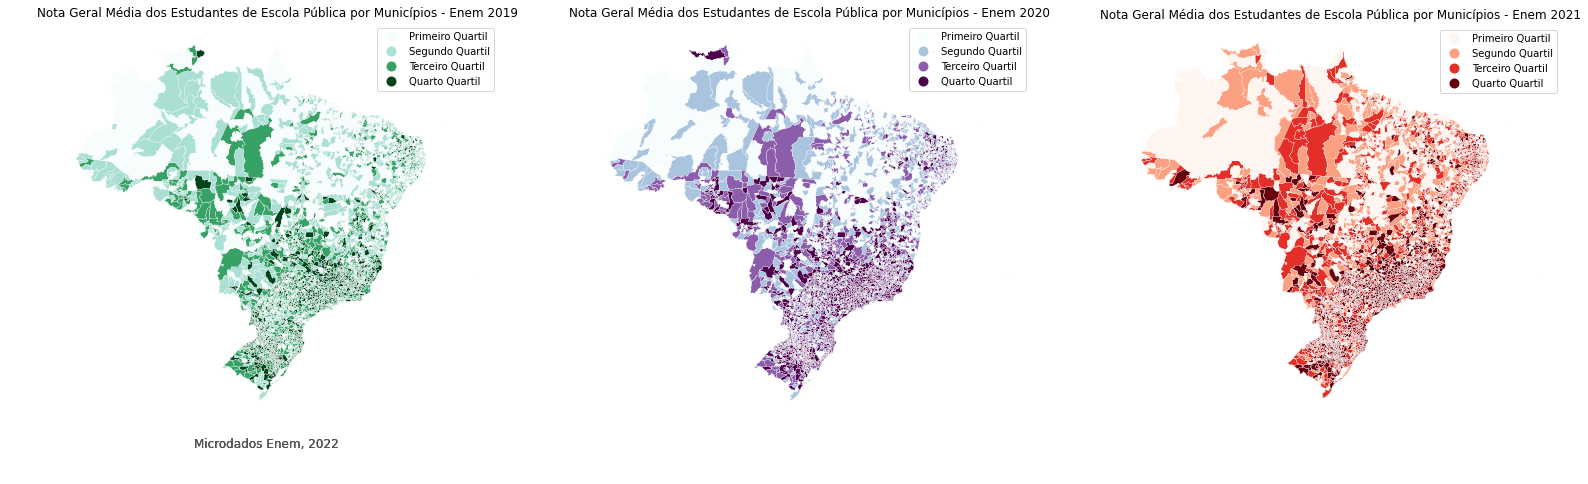

In [56]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,3, figsize=(27, 8))

ax = ax.flatten()
cmaps = ['BuGn', 'BuPu', 'Reds']
plots = get_trienio(geo_med_enem_pub)
anos = ['2019', '2020', '2021']

for i, plot in enumerate(plots):
    ax[i] = plot.plot(column='NT_MEDIA_QUARTIL',categorical=True, cmap=cmaps[i], legend=True, linewidth=0.1, ax=ax[i], edgecolor='1', zorder=1)
    ax[i].axis('off')
    ax[i].set_title(f'Nota Geral Média dos Estudantes de Escola Pública por Municípios - Enem {anos[i]}', fontdict={'fontsize': '12', 'fontweight' : '3'})
    ax[i].annotate('Microdados Enem, 2022',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    sh_br.boundary.plot(linewidth=0.3, color='black', zorder=2, ax=ax[i])


### Nota geral média dos municípios beneficiários do programa banda larga nas escolas

In [4]:
# PBLE
pble = pd.read_csv('../../Resultados/Agg/PBLE/PBLE_agg_total_municipio.csv')
# Consertando entradas erradas para nome de município
pble.Municipio = pble.Municipio.replace({'Biritiba-Mirim':'Biritiba Mirim','São Luís do Paraitinga':'São Luiz do Paraitinga','Atilio Vivacqua':'Atílio Vivácqua','Lauro Muller':'Lauro Müller', 'Grão Pará':'Grão-Pará', 'São Cristovão do Sul':'São Cristóvão do Sul'})

In [58]:
pble.head()

,Ano_Ativacao,Municipio,velocidade_median,velocidade_mean
0,2018,Além Paraíba,2.0,2.000000
1,2018,Americana,4.0,4.333333
2,2018,Amparo,4.0,4.000000
3,2018,Ananindeua,2.0,2.000000
4,2018,Apiaí,4.0,4.000000


In [67]:
print('Municípios fora do join:', len(pble[~pble['Municipio'].isin(sh_mun.NM_MUN.unique())]))

Municípios fora do join: 0


In [6]:
pble_geo = gpd.GeoDataFrame(pble.merge(sh_mun, left_on='Municipio', right_on='NM_MUN', how='right'))

In [80]:
pble_geo.head()

,Ano_Ativacao,Municipio,velocidade_median,velocidade_mean,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry
0,2021.0,Alta Floresta D'Oeste,2.0,2.0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8..."
1,2018.0,Ariquemes,10.0,10.0,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736..."
2,NaN,NaN,NaN,NaN,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3..."
3,NaN,NaN,NaN,NaN,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.00080 -11.29737, -61.00103 -11.3..."
4,NaN,NaN,NaN,NaN,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0..."


In [7]:
pble_geo['ATIVADO_2019'] = pble_geo['Ano_Ativacao'].apply(lambda x: "Sim" if x <= 2019 and x != np.nan else "Não")
pble_geo['ATIVADO_2020'] = pble_geo['Ano_Ativacao'].apply(lambda x: "Sim" if x <= 2020 and x != np.nan else "Não")
pble_geo['ATIVADO_2021'] = pble_geo['Ano_Ativacao'].apply(lambda x: "Sim" if x <= 2021 and x != np.nan else "Não")

/tmp/ipykernel_118574/2871512694.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


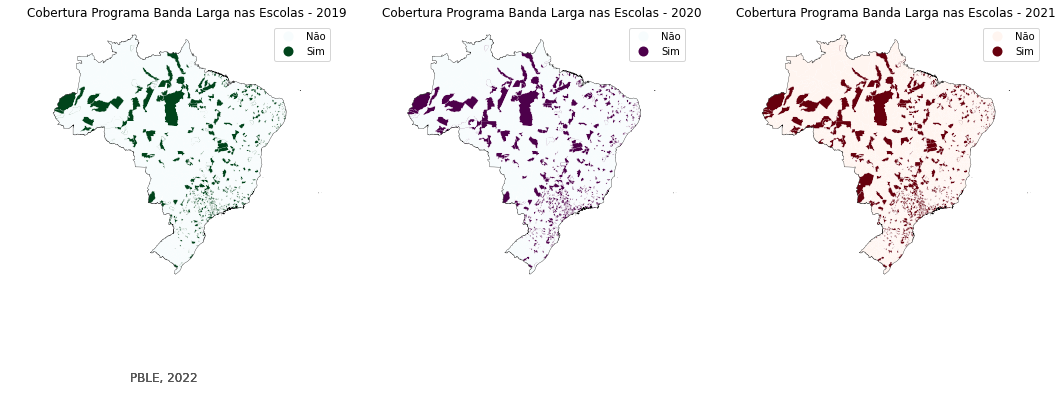

In [13]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1,3, figsize=(18, 7))

ax = ax.flatten()
cmaps = ['BuGn', 'BuPu', 'Reds']
anos = ['2019', '2020', '2021']

for i in range(3):
    ax[i] = pble_geo.plot(column=f'ATIVADO_{anos[i]}',categorical=True, cmap=cmaps[i], legend=True, linewidth=0.1, ax=ax[i], edgecolor='1', zorder=1)
    ax[i].axis('off')
    ax[i].set_title(f'Cobertura Programa Banda Larga nas Escolas - {anos[i]}', fontdict={'fontsize': '12', 'fontweight' : '3'})
    ax[i].annotate('PBLE, 2022',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    sh_br.boundary.plot(linewidth=0.3, color='black', zorder=2, ax=ax[i])

plt.show()


### Correlação Velocidade Internet X Nota Geral Média escolas públicas município

In [14]:
# PBLE
pble = pd.read_csv('../../Resultados/Agg/PBLE/PBLE_agg_total_municipio.csv')
# Consertando entradas erradas para nome de município
pble.Municipio = pble.Municipio.replace({'Biritiba-Mirim':'Biritiba Mirim','São Luís do Paraitinga':'São Luiz do Paraitinga','Atilio Vivacqua':'Atílio Vivácqua','Lauro Muller':'Lauro Müller', 'Grão Pará':'Grão-Pará', 'São Cristovão do Sul':'São Cristóvão do Sul'})

In [28]:
censo_pub_pvd = pd.read_parquet('../../Resultados/Agg/Censo Escolar/Ens. Méd/dados_censo-esc_agg_pub_pvd-0.parquet').reset_index()

In [18]:
med_enem = pd.read_parquet('../../Resultados/Agg/ENEM/anual/notas/medio_nota_pub_pvd.parquet').reset_index().drop(columns=['TP_DEPENDENCIA_ADM_ESC','index','SG_UF_ESC'])
median_enem = pd.read_parquet('../../Resultados/Agg/ENEM/2019/pub_pvd_mediana.parquet').reset_index()
med_enem.TP_ESCOLA = med_enem.TP_ESCOLA.replace(categorical_labels['TP_ESCOLA'])
med_enem.NU_ANO = med_enem.NU_ANO.astype(int)

# Selecionando apenas escolas públicas
med_enem_pub = med_enem[med_enem.TP_ESCOLA == 'Pública']

In [ ]:
pble_nota = pble.merge(med_enem_pub, left_on='Municipio', right_on='NO_MUNICIPIO_ESC', how='inner')

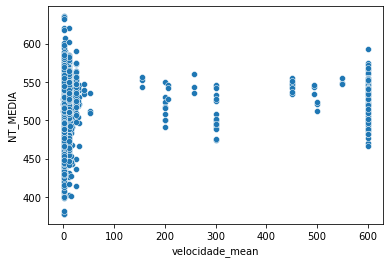

In [33]:
sns.scatterplot(x='velocidade_mean', y='NT_MEDIA', data=pble_nota);

Nenhuma evidência de correlação entre a banda larga e a nota média para as escolas do PBLE

In [35]:
enem_censo = med_enem_pub.merge(censo_pub_pvd, left_on=['CO_MUNICIPIO_ESC','NU_ANO'], right_on=['CO_MUNICIPIO','NU_ANO_CENSO'], how='inner')

In [46]:
corr.columns

Index(['NU_ANO', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'TP_ESCOLA',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'NT_MEDIA', '__null_dask_index__', 'NU_ANO_CENSO',
       'SG_UF', 'CO_MUNICIPIO', 'TP_DEPENDENCIA_AGG',
       'TP_SITUACAO_FUNCIONAMENTO', 'IN_AGUA_POTAVEL',
       'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_AREA_VERDE',
       'IN_BANHEIRO', 'IN_BIBLIOTECA', 'IN_LABORATORIO_INFORMATICA',
       'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM', 'IN_INTERNET_ADMINISTRATIVO',
       'IN_INTERNET_COMUNIDADE', 'IN_ACESSO_INTERNET_COMPUTADOR',
       'IN_ACES_INTERNET_DISP_PESSOAIS', 'IN_BANDA_LARGA', 'IN_EXAME_SELECAO',
       'QT_DOC_MED', 'TP_REDE_LOCAL'],
      dtype='object')

In [45]:
corr.head()

,NU_ANO,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NT_MEDIA,...,IN_INTERNET,IN_INTERNET_APRENDIZAGEM,IN_INTERNET_ADMINISTRATIVO,IN_INTERNET_COMUNIDADE,IN_ACESSO_INTERNET_COMPUTADOR,IN_ACES_INTERNET_DISP_PESSOAIS,IN_BANDA_LARGA,IN_EXAME_SELECAO,QT_DOC_MED,TP_REDE_LOCAL
0,2019,1100015,Alta Floresta D'Oeste,Pública,468.857522,491.323684,503.919298,503.683186,589.824561,512.695044,...,0.400,0.400,0.400000,0.00,0.400000,0.000000,1.0,0.000000,17.0,9.0
1,2019,1100023,Ariquemes,Pública,467.460000,495.127916,511.167113,513.599592,569.330784,513.760205,...,0.875,0.625,0.875000,0.25,0.750000,0.625000,1.0,0.250000,30.0,3.0
2,2019,1100023,Ariquemes,Pública,467.460000,495.127916,511.167113,513.599592,569.330784,513.760205,...,1.000,1.000,1.000000,0.00,1.000000,0.000000,1.0,0.000000,13.0,2.0
3,2019,1100031,Cabixi,Pública,441.929412,470.415000,470.985000,467.000000,467.000000,474.951765,...,1.000,0.000,1.000000,0.00,1.000000,0.500000,1.0,0.000000,11.0,2.0
4,2019,1100049,Cacoal,Pública,469.611833,491.141129,506.188710,519.650833,546.806452,508.188748,...,0.750,0.500,0.583333,0.00,0.666667,0.333333,1.0,0.083333,13.5,3.0


In [52]:
# Limpando dados para análise de correlação
corr = enem_censo.copy()
corr = corr[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'NT_MEDIA','IN_AGUA_POTAVEL',
       'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_AREA_VERDE',
       'IN_BANHEIRO', 'IN_BIBLIOTECA', 'IN_LABORATORIO_INFORMATICA',
       'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM', 'IN_INTERNET_ADMINISTRATIVO',
       'IN_INTERNET_COMUNIDADE', 'IN_ACESSO_INTERNET_COMPUTADOR',
       'IN_ACES_INTERNET_DISP_PESSOAIS', 'IN_BANDA_LARGA', 'IN_EXAME_SELECAO',
       'QT_DOC_MED', 'TP_REDE_LOCAL']].corr()

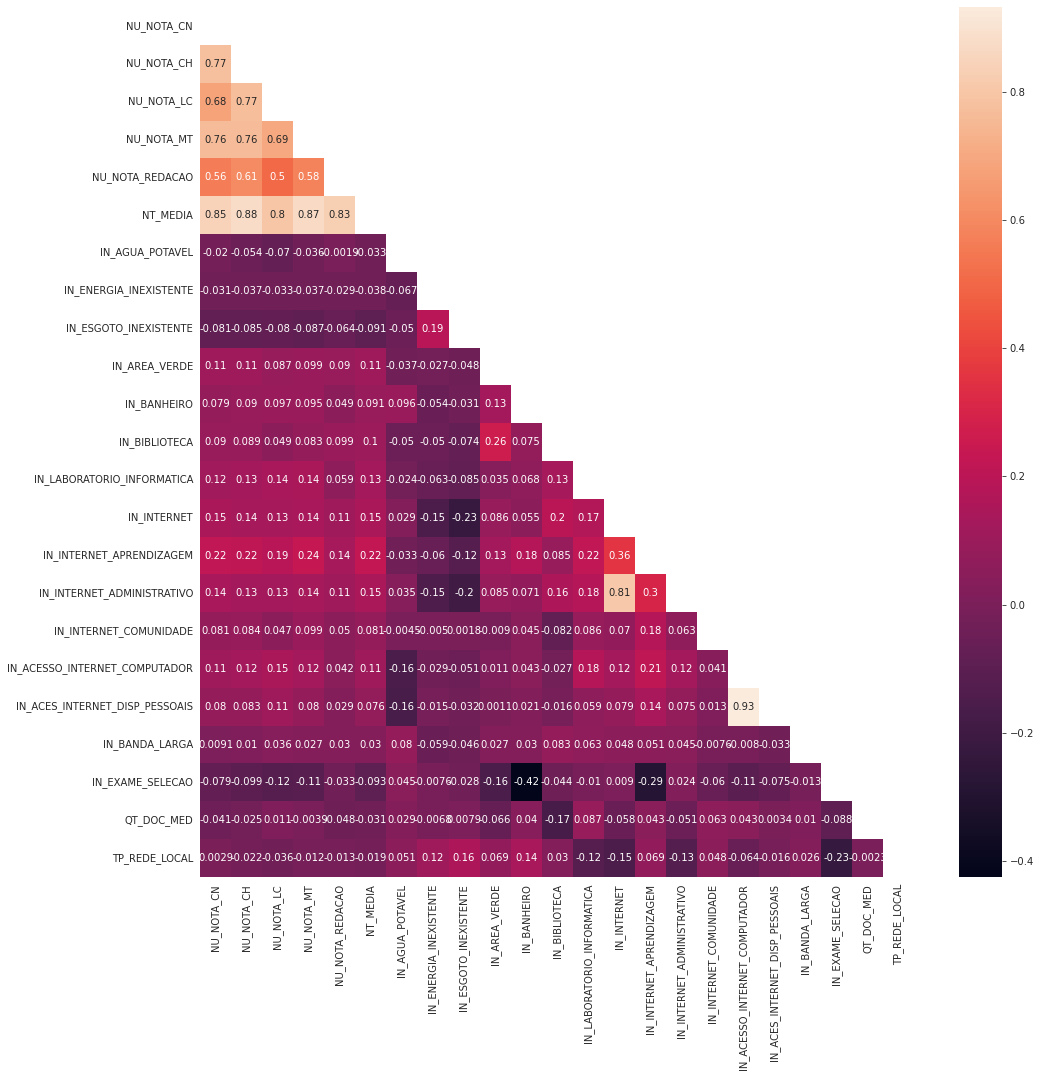

In [58]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16,16))
    ax = sns.heatmap(corr, mask=mask, square=False, annot=True)